# Data Visualization Exploration

### Scalar value ideas for dashboard:
`could try to emulate https://ncov19.us/ top bar`
- avg rating of recommendations/movies you liked
- avg year of recommendations 
- "Your decade" (ex 80s) generated from recommendations
- three favorite genres (or two favorite genres and one recommendation)

### Chart ideas for dashboard:
- genre distribution of your watchlist or recommendation list
- avg rating for each genre in your ratings

### Random notes:
- recommendations table should be adjusted, each row should be a single movie
- it would make it so that movie_id is all we need to store (with user_id)
- then to get all movie data we just JOIN on imdb_movies 
- because of the structure some of the processes are slowed down by being required to get movie_data one movie at a time

In [3]:
# imports
import pandas as pd 
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
from heapq import nlargest 
import os
from dotenv import load_dotenv

In [ ]:
# load .env file for keys
load_dotenv()

In [4]:
# create connection to prod DB
connection = psycopg2.connect(
                            user=os.getenv('db_user'),
                            password=os.getenv('db_password'),
                            host=os.getenv('db_host'),
                            port="5432",
                            database=os.getenv('db_user')
                            )

## Recommendation Exploration

In [5]:
# get all recommendations 
cursor = connection.cursor()
query = 'SELECT * FROM recommendations'
cursor.execute(query)
recommendations = cursor.fetchall()
cursor.close()
len(recommendations)

190

In [6]:
# get all movies (will merge on rec df later)
cursor = connection.cursor()
postgreSQL_select_Query = "SELECT movie_id, is_adult, runtime_minutes, genres FROM imdb_movies;"
cursor.execute(postgreSQL_select_Query)
all_movies = cursor.fetchall()
len(all_movies)

301967

In [7]:
# make movie_df
movie_ids = []
is_adults = []
times = []
genres = []

for movie in all_movies:
    movie_ids.append(movie[0])
    is_adults.append(movie[1])
    times.append(movie[2])
    genres.append(movie[3])

movie_df = pd.DataFrame({
    'movie_id': movie_ids,
    'is_adult': is_adults,
    'runtime_minutes': times,
    'genres': genres
})
print(movie_df.shape)
movie_df.head()

(301967, 4)


,movie_id,is_adult,runtime_minutes,genres
0,1051218,0,80,Comedy
1,1051231,0,106,"Documentary,Sport"
2,10512418,0,135,"Biography,History,Thriller"
3,1051244,0,120,Musical
4,10505048,0,100,\N


In [8]:
recommendations[0]
"""
user_id
recommendation_id
recommendation_json
date
model_type
"""

'\nuser_id\nrecommendation_id\nrecommendation_json\ndate\nmodel_type\n'

In [9]:
# store rec info in df
user_ids = []
rec_ids = []
rec_titles = []
rec_years = []
rec_ratings = []
rec_votes = []
rec_movie_ids = []
rec_gems = []
dates = []
model_types = []

"""
Could just save the movie_id
and merge a movie_data df to df made with this info
on movie_id
"""
for rec in recommendations:
    for unit in rec[2]:
        user_ids.append(rec[0])
        rec_ids.append(rec[1])
        rec_titles.append(unit['Title'])
        rec_years.append(unit['Year'])
        rec_ratings.append(unit['Mean Rating'])
        rec_votes.append(unit['Votes'])
        rec_movie_ids.append(unit['ID'])
        rec_gems.append(unit['Gem'])
        dates.append(rec[3])
        model_types.append(rec[4])

len(user_ids)

6823

In [10]:
# make df
df = pd.DataFrame({
    'user_id': user_ids,
    'rec_id': rec_ids,
    'title': rec_titles,
    'year': rec_years,
    'avg_rating': rec_ratings,
    'votes': rec_votes,
    'movie_id': rec_movie_ids,
    'gem': rec_gems,
    'date': dates,
    'model_type': model_types
})
print(df.shape)
df.head()

(6823, 10)


,user_id,rec_id,title,year,avg_rating,votes,movie_id,gem,date,model_type
0,277844,a983018cbd3e502f1bc44af46310ab08,Breaking News,2004,6.7,4906,0414931,False,2020-03-13 00:00:00+00:00,ratings model
1,277844,a983018cbd3e502f1bc44af46310ab08,OSS 117: Lost in Rio,2009,6.9,12187,1167660,False,2020-03-13 00:00:00+00:00,ratings model
2,277844,a983018cbd3e502f1bc44af46310ab08,The Girl from Monaco,2008,5.8,1909,1139800,False,2020-03-13 00:00:00+00:00,ratings model
3,277844,a983018cbd3e502f1bc44af46310ab08,Witchhammer,1970,7.9,1564,0064546,False,2020-03-13 00:00:00+00:00,ratings model
4,277844,a983018cbd3e502f1bc44af46310ab08,Return of the One-Armed Swordsman,1969,7.2,1060,0064265,False,2020-03-13 00:00:00+00:00,ratings model


In [11]:
# merge with movie_df on movie_id to get additional movie info
df = pd.merge(df, movie_df, on='movie_id', how='inner')
print(df.shape)
df.head()

(6820, 13)


,user_id,rec_id,title,year,avg_rating,votes,movie_id,gem,date,model_type,is_adult,runtime_minutes,genres
0,277844,a983018cbd3e502f1bc44af46310ab08,Breaking News,2004,6.7,4906,0414931,False,2020-03-13 00:00:00+00:00,ratings model,0,90,"Action,Crime,Drama"
1,277844,cff35baa7012b4303bb577312b0cc9ee,Breaking News,2004,6.7,4906,0414931,False,2020-03-16 00:00:00+00:00,ratings model,0,90,"Action,Crime,Drama"
2,284162,b40e6f26720674f9e0030f55803a29d5,Breaking News,2004,6.7,4906,0414931,False,2020-03-16 00:00:00+00:00,ratings model,0,90,"Action,Crime,Drama"
3,314295,81cffda9b335d5a2554ea64f4fd60386,Breaking News,2004,6.7,4906,0414931,False,2020-03-26 22:19:43.415157+00:00,ratings model,0,90,"Action,Crime,Drama"
4,314306,bf1894187af9e62cc763525ae3a996df,Breaking News,2004,6.7,4906,0414931,False,2020-03-26 22:22:13.998028+00:00,ratings model,0,90,"Action,Crime,Drama"


In [22]:
# get len of all movie_ids
lengths = {}

for movie_id in df['movie_id'].values:
    if len(movie_id) in lengths:
        lengths[len(movie_id)] += 1
    else:
        lengths[len(movie_id)] = 1
        print(movie_id)

lengths

0414931
10883004


{7: 6750, 8: 70}

In [12]:
# no variance here, can probably drop
df['model_type'].value_counts()

ratings model    6820
Name: model_type, dtype: int64

In [13]:
df.dtypes

user_id                                                        int64
rec_id                                                        object
title                                                         object
year                                                          object
avg_rating                                                    object
votes                                                         object
movie_id                                                      object
gem                                                             bool
date               datetime64[ns, psycopg2.tz.FixedOffsetTimezone...
model_type                                                    object
is_adult                                                       int64
runtime_minutes                                                int64
genres                                                        object
dtype: object

In [14]:
# replace 'None' with np.NaN
df = df.replace({'None': np.NaN})

In [15]:
# fix incorrect columns
df['avg_rating'] = df['avg_rating'].astype('float64')
# have to use float for these cause NaNs
df['year'] = df['year'].astype('float64') 
df['votes'] = df['votes'].astype('float64')
df.dtypes

user_id                                                        int64
rec_id                                                        object
title                                                         object
year                                                         float64
avg_rating                                                   float64
votes                                                        float64
movie_id                                                      object
gem                                                             bool
date               datetime64[ns, psycopg2.tz.FixedOffsetTimezone...
model_type                                                    object
is_adult                                                       int64
runtime_minutes                                                int64
genres                                                        object
dtype: object

In [16]:
user_recs = df.groupby(by='user_id')
len(user_recs)

78

1 7.731249999999996 1970.075
{'Comedy': 36, 'Drama': 74, 'Romance': 14, 'Crime': 10, 'Thriller': 8, 'Adventure': 5, 'War': 10, 'Film-Noir': 6, 'Music': 3, 'Documentary': 3, 'Mystery': 3}


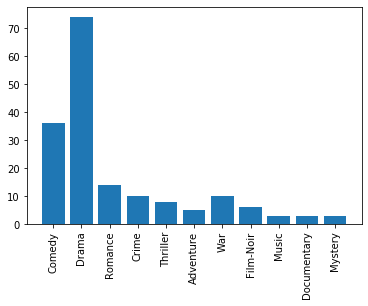

3 7.106521739130437 1995.4130434782608
{'Action': 17, 'Adventure': 14, 'Thriller': 14, 'Drama': 19, 'Horror': 10, 'Animation': 2, 'Mystery': 5, 'Biography': 1, 'History': 1, 'Music': 3, 'Romance': 3, 'Comedy': 4, 'Crime': 6, 'Documentary': 1, 'Sci-Fi': 7, 'Fantasy': 4, 'Family': 2, 'Western': 2, 'War': 1}


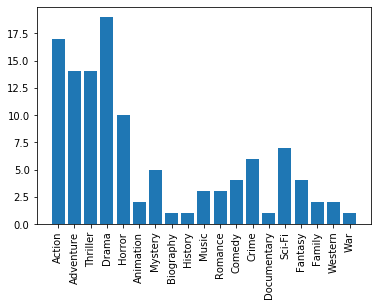

4 7.737500000000003 1968.4191176470588
{'Comedy': 64, 'Drama': 130, 'Fantasy': 16, 'Romance': 26, 'Adventure': 15, 'Biography': 7, 'Crime': 18, 'Thriller': 8, 'War': 16, 'Film-Noir': 11, 'Music': 6, 'Mystery': 16, 'Horror': 1}


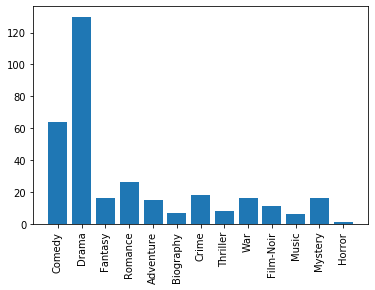

6 7.733014354066988 1971.7081339712918
{'Comedy': 61, 'Drama': 198, 'Fantasy': 16, 'Romance': 29, 'War': 27, 'Adventure': 16, 'Biography': 4, 'Crime': 20, 'Thriller': 8, 'Mystery': 9, 'Music': 2, 'Film-Noir': 26, 'Documentary': 8, 'Action': 1}


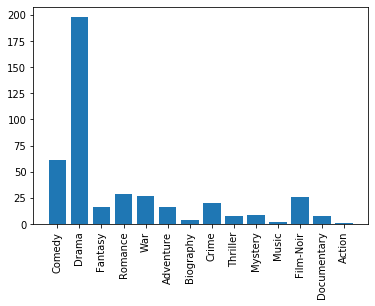

11 7.134883720930234 1996.3953488372092
{'Action': 17, 'Adventure': 13, 'Thriller': 9, 'Drama': 27, 'Biography': 5, 'History': 3, 'Music': 2, 'Romance': 6, 'Documentary': 2, 'Crime': 6, 'Fantasy': 5, 'Mystery': 4, 'Sci-Fi': 2, 'War': 5, 'Family': 3, 'Animation': 3, 'Comedy': 4}


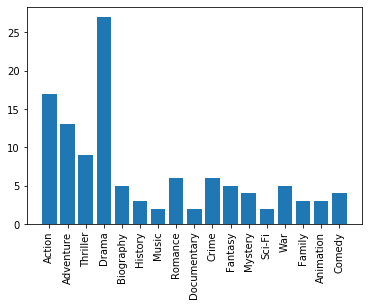

In [17]:
# get scaler values
counter = 0
for user, data in user_recs:
    genre_counts = {}
    print(user, data['avg_rating'].mean(), data['year'].mean())
    for genre_string in data['genres'].values:
        genres = genre_string.split(',')
        for genre in genres:
            if genre in genre_counts:
                genre_counts[genre] += 1
            else:
                genre_counts[genre] = 1
    print(genre_counts)
    plt.bar(range(len(genre_counts)), genre_counts.values())
    plt.xticks(range(len(genre_counts)), genre_counts.keys(), rotation=90)
    plt.show()
    counter += 1
    if counter == 5:
        break

In [18]:
# refactor to a function 
"""
Currently gets user dashboard data
relating to recommendations made to the user

Because the movie data in recommendations is stored
in a JSON object this function is required to get the additional
movie data one by one rather than JOIN the movie data on the 
initial select query. Should adjust how recommendations are stored to 
improve speed
"""
def get_user_dashboard_data(user_id):
    cursor = connection.cursor()
    query = f"SELECT * FROM recommendations WHERE user_id = {user_id};"
    cursor.execute(query)
    recommendations = cursor.fetchall()
    
    rec_ids = []
    rec_titles = []
    rec_years = []
    rec_ratings = []
    rec_votes = []
    rec_movie_ids = []
    # rec_gems = []
    # dates = []
    genres = []
    # don't think it's needed
    # model_types = []

    for rec in recommendations:
        for unit in rec[2]:
            movie_query = f"SELECT genres FROM imdb_movies WHERE movie_id = '{unit['ID']}';"
            cursor.execute(movie_query)
            movie_data = cursor.fetchone()
            rec_ids.append(rec[1])
            rec_titles.append(unit['Title'])
            rec_years.append(unit['Year'])
            rec_ratings.append(unit['Mean Rating'])
            rec_votes.append(unit['Votes'])
            rec_movie_ids.append(unit['ID'])
            genres.append(movie_data[0])
            # rec_gems.append(unit['Gem'])
            # dates.append(rec[3])
            # model_types.append(rec[4])
            
    cursor.close()
    data = pd.DataFrame({
        'rec_id': rec_ids,
        'title': rec_titles,
        'year': rec_years,
        'avg_rating': rec_ratings,
        'votes': rec_votes,
        'movie_id': rec_movie_ids,
        'genres': genres
    })
    
    genre_counts = {}
    for genre_string in data['genres'].values:
        genres = genre_string.split(',')
        for genre in genres:
            if genre in genre_counts:
                genre_counts[genre] += 1
            else:
                genre_counts[genre] = 1
    plt.bar(range(len(genre_counts)), genre_counts.values())
    plt.xticks(range(len(genre_counts)), genre_counts.keys(), rotation=90)
    plt.show()
    top_three = nlargest(3, genre_counts, key=genre_counts.get) 
    for key in top_three:
        print(f"{key}: {genre_counts[key]}")
    return round(data['avg_rating'].mean(), 2), int(data['year'].mean())

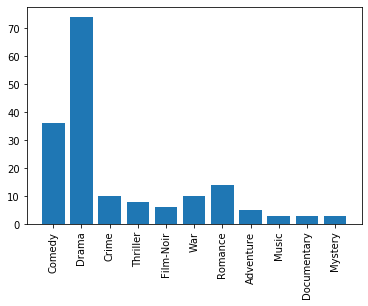

Drama: 74
Comedy: 36
Romance: 14


(7.73, 1970)

In [19]:
get_user_dashboard_data(1)

## Rating Exploration

In [24]:
# get all ratings
cursor = connection.cursor()
query = 'SELECT user_id, name, year, rating, id FROM user_imdb_ratings;'
cursor.execute(query)
ratings = cursor.fetchall()
cursor.close()
len(ratings)

20337

In [25]:
# make ratings data into df
user_ids = []
names = []
years = []
user_ratings = []
movie_ids = []

for rating in ratings:
    user_ids.append(rating[0])
    names.append(rating[1])
    years.append(rating[2])
    user_ratings.append(rating[3])
    movie_ids.append(str(rating[4]))

ratings_df = pd.DataFrame({
    'user_id': user_ids,
    'title': names,
    'year': years,
    'rating': user_ratings,
    'movie_id': movie_ids
})
print(ratings_df.shape)
ratings_df.head()

(20337, 5)


,user_id,title,year,rating,movie_id
0,11,Rear Window,1954,5.0,1323
1,11,Ran,1985,4.5,1938
2,11,Badlands,1973,4.5,2390
3,11,It,2017,4.5,2817
4,11,The Help,2011,4.5,5027


In [26]:
# get len of all movie_ids in ratings_df
lengths = {}

for movie_id in ratings_df['movie_id'].values:
    if len(movie_id) in lengths:
        lengths[len(movie_id)] += 1
    else:
        lengths[len(movie_id)] = 1
        print(movie_id)

lengths

1323
11293
121
1
10


{4: 9000, 5: 10338, 3: 900, 1: 9, 2: 90}

In [58]:
ratings_df_merged = pd.merge(ratings_df, movie_df, on='movie_id', how='inner')
print(ratings_df_merged.shape)
ratings_df_merged.head()

(0, 8)


,user_id,title,year,rating,movie_id,is_adult,runtime_minutes,genres


Seems that id in user_imdb ratings doesn't match up with imdb_id but that doesn't make much since because that column doesn't have a movie_id column. Hmmm